# A Multi-Layer Fully Connected Neural Network for lesion classification

## 1. Motivation for FCNs
Weaknesses of k-NN classifier
- Classifier must remember all the training data
- Classification is computationally expensive since it requires alot of comparisons

Solution; Parameterized mapping from images to label scores
- Simple case is a linear classifier such as <br><math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>s</mi>
  <mo>=</mo>
  <mi>W</mi>
  <mi>x</mi>
</math> <br><math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>W</mi>
</math> in our case is a [2x190000] matrix <br><math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>x</mi>
</math> is a [190000x1] column vector <br>s becomes a [2x1] matrix of class scores
- A nueral network instead computes <br><math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>s</mi>
  <mo>=</mo>
  <msub>
    <mi>W</mi>
    <mn>2</mn>
  </msub>
  <mo movablelimits="true" form="prefix">max</mo>
  <mo stretchy="false">(</mo>
  <mn>0</mn>
  <mo>,</mo>
  <msub>
    <mi>W</mi>
    <mn>1</mn>
  </msub>
  <mi>x</mi>
  <mo stretchy="false">)</mo>
</math> <br> The key distinction from a linear classifier is the function <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>m</mi>
  <mi>a</mi>
  <mi>x</mi>
  <mo stretchy="false">(</mo>
  <mn>0</mn>
  <mo>,</mo>
  <mo>&#x2212;<!-- − --></mo>
  <mo stretchy="false">)</mo>
</math> which is a non linearity applied elementwise
- A three-layer neural network would therefore be s=W3max(0,W2max(0,W1x))

Biological motivation

 <img src="images/biological_neuron_model.jpg" width="80%" />

 Stacked together to form a fully connected nn

 <img src="images/fc_neural_net.jpg" width="80%" />



## 2. Data preparation

In [2]:
# some setup code for this notebook
import numpy as np
import matplotlib.pyplot as plt
from functions import data, Timer
timer = Timer()

# This makes matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

#### The ultra sound scan data
- 163 scans total, clinically confirmed as having either bening or malignant (cancerous) lesions 
- 100 scans for training, 63 for testing
- Training data was passed through 7 transformations to give us 800 training images total
- Testing images not transformed
- Both training and testing images were resized to 360X528
- Raw pngs then converted to numpy arrays and saved

In [2]:
#  load the data
x_train, y_train, x_test, y_test = data.getData()

print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (800, 224, 224, 3)
Training labels shape:  (800, 1)
Test data shape:  (63, 224, 224, 3)
Test labels shape:  (63, 1)


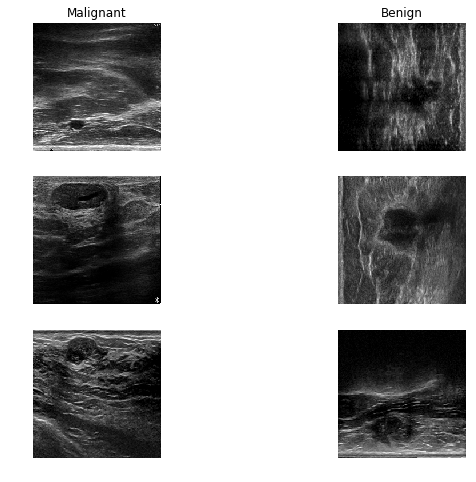

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = [1, 0]
num_classes = len(classes)
samples_per_class = 3
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            if cls == 1: title = 'Malignant'
            else: title = 'Benign'
            plt.title(title)
plt.show()

In [4]:
# Reshape the image data into rows
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))

In [5]:
# Subsample the training data for faster code execution in this demo
# if nmu_training = 800 then no subsampling is taking place
num_training = 800
mask = list(range(num_training))
x_train = x_train[mask]
y_train = y_train[mask]
num_test = 63

In [6]:
# confirm shapes
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (800, 150528)
Training labels shape:  (800, 1)
Test data shape:  (63, 150528)
Test labels shape:  (63, 1)


In [7]:
def getModelMemoryUsage(batch_size, model):
    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return str(gbytes) + "GB " , str(gbytes*2) + "GB "

## 3. Building the fcn with TensorFlow and Keras

In [8]:
# import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

Using TensorFlow backend.


In [11]:
# finally we build the model
dimensions = x_train.shape[1]
print(dimensions, 'Dimensions')

hidden_1 = 256
hidden_2 = 256
drop_out_rate = 0.5
batch_size = 16

model = Sequential()
model.add(Dense(hidden_1, input_dim=dimensions, activation='relu'))
model.add(Dropout(drop_out_rate))
model.add(Dense(hidden_2, activation='relu'))
model.add(Dropout(drop_out_rate))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

150528 Dimensions


Lets see the model

In [12]:
# visualize model
model.summary()
gpu, ram = getModelMemoryUsage(batch_size, model)
print("GPU Memory:" + gpu + "RAM:" + ram)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               38535424  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 38,601,473
Trainable params: 38,601,473
Non-trainable params: 0
_________________________________________________________________
GPU Memory:2.301GB RAM:4.602GB 


## 3

Overfitting

<img src="images/overfitting.png">

Avoided using many techniques; including cross validation


In [13]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
best_model_file = 'best_fcn_model.h5' 
best_model = ModelCheckpoint(best_model_file, verbose=True, save_best_only=True)
network_histories = []
def fold(test_size=0.15, random_state=89, epochs=10):
    x_trf, x_val, y_trf, y_val = train_test_split(
        x_train, 
        y_train, 
        test_size=test_size, 
        random_state=random_state)
    t = Timer()
    
        # early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1) 
    t.start()
    network_history = model.fit(x_trf, y_trf, 
                                validation_data = (x_val, y_val),
                                epochs=epochs, 
                                batch_size=batch_size, verbose=True,
                                callbacks=[best_model])
    network_histories.append(network_history)
    t.stop('Training FCN with test %s and random state %s' % (str(test_size), str(random_state)))

In [15]:
fold()

Train on 680 samples, validate on 120 samples
Epoch 1/10
680/680 [==============================] - 11s 17ms/step - loss: 10.1023 - acc: 0.3662 - val_loss: 11.4254 - val_acc: 0.2833

Epoch 00001: val_loss improved from inf to 11.42538, saving model to best_fcn_model.h5
Epoch 2/10
680/680 [==============================] - 8s 12ms/step - loss: 8.1303 - acc: 0.4912 - val_loss: 4.5668 - val_acc: 0.7167

Epoch 00002: val_loss improved from 11.42538 to 4.56679, saving model to best_fcn_model.h5
Epoch 3/10
680/680 [==============================] - 8s 12ms/step - loss: 7.0755 - acc: 0.5588 - val_loss: 4.5668 - val_acc: 0.7167

Epoch 00003: val_loss did not improve
Epoch 4/10
680/680 [==============================] - 9s 13ms/step - loss: 6.8887 - acc: 0.5706 - val_loss: 4.5668 - val_acc: 0.7167

Epoch 00004: val_loss did not improve
Epoch 5/10
680/680 [==============================] - 8s 12ms/step - loss: 6.7929 - acc: 0.5765 - val_loss: 4.5668 - val_acc: 0.7167- acc: 0.5

Epoch 00005: val_

In [16]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

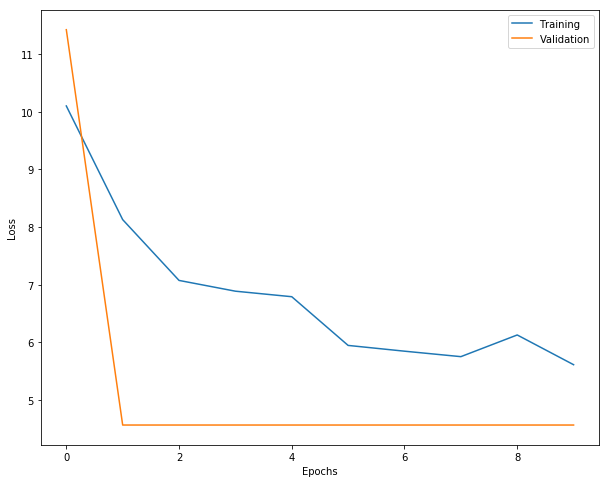

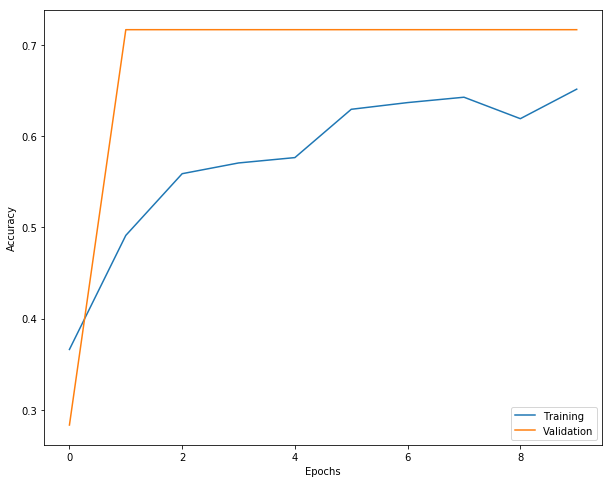

In [18]:
plot_history(network_histories[0])

In [19]:
# multi fold cross validation
test_sizes = [0.1, 0.2, 0.3, 0.5, 0.6]
random_states = [1, 5, 15, 50, 100]
epochs = 10
timer.start()
for test_size in test_sizes:
    for random_state in random_states:
        fold(test_size, random_state, epochs)
timer.stop('Training %d models' % len(test_sizes)*len(random_states))
        

Train on 720 samples, validate on 80 samples
Epoch 1/10
720/720 [==============================] - 9s 13ms/step - loss: 5.4345 - acc: 0.6625 - val_loss: 6.0443 - val_acc: 0.6250

Epoch 00001: val_loss did not improve
Epoch 2/10
720/720 [==============================] - 8s 12ms/step - loss: 5.6114 - acc: 0.6514 - val_loss: 6.0443 - val_acc: 0.6250

Epoch 00002: val_loss did not improve
Epoch 3/10
720/720 [==============================] - 9s 12ms/step - loss: 5.5223 - acc: 0.6569 - val_loss: 6.0443 - val_acc: 0.6250

Epoch 00003: val_loss did not improve
Epoch 4/10
720/720 [==============================] - 9s 12ms/step - loss: 5.6128 - acc: 0.6514 - val_loss: 6.0443 - val_acc: 0.6250

Epoch 00004: val_loss did not improve
Epoch 5/10
720/720 [==============================] - 8s 12ms/step - loss: 5.5007 - acc: 0.6583 - val_loss: 6.0443 - val_acc: 0.6250

Epoch 00005: val_loss did not improve
Epoch 6/10
720/720 [==============================] - 8s 12ms/step - loss: 5.5666 - acc: 0.6542

640/640 [==============================] - 8s 12ms/step - loss: 7.1162 - acc: 0.5562 - val_loss: 5.3391 - val_acc: 0.6687

Epoch 00009: val_loss did not improve
Epoch 10/10
640/640 [==============================] - 7s 12ms/step - loss: 6.6412 - acc: 0.5859 - val_loss: 5.3391 - val_acc: 0.6687

Epoch 00010: val_loss did not improve
Timing:: took 77 second(s) Training FCN with test 0.2 and random state 50
Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 8s 12ms/step - loss: 7.0171 - acc: 0.5625 - val_loss: 5.1376 - val_acc: 0.6813

Epoch 00001: val_loss did not improve
Epoch 2/10
640/640 [==============================] - 8s 12ms/step - loss: 6.8610 - acc: 0.5719 - val_loss: 5.1376 - val_acc: 0.6813cc:

Epoch 00002: val_loss did not improve
Epoch 3/10
640/640 [==============================] - 8s 12ms/step - loss: 6.7190 - acc: 0.5813 - val_loss: 5.1376 - val_acc: 0.6813

Epoch 00003: val_loss did not improve
Epoch 4/10
640/640 [=======

400/400 [==============================] - 5s 13ms/step - loss: 6.6986 - acc: 0.5825 - val_loss: 5.4802 - val_acc: 0.6600

Epoch 00008: val_loss did not improve
Epoch 9/10
400/400 [==============================] - 5s 13ms/step - loss: 6.0994 - acc: 0.6200 - val_loss: 5.4802 - val_acc: 0.6600

Epoch 00009: val_loss did not improve
Epoch 10/10
400/400 [==============================] - 5s 13ms/step - loss: 6.4209 - acc: 0.6000 - val_loss: 5.4802 - val_acc: 0.6600

Epoch 00010: val_loss did not improve
Timing:: took 53 second(s) Training FCN with test 0.5 and random state 15
Train on 400 samples, validate on 400 samples
Epoch 1/10
400/400 [==============================] - 5s 13ms/step - loss: 6.8247 - acc: 0.5750 - val_loss: 5.2384 - val_acc: 0.6750

Epoch 00001: val_loss did not improve
Epoch 2/10
400/400 [==============================] - 5s 13ms/step - loss: 6.4634 - acc: 0.5975 - val_loss: 5.2384 - val_acc: 0.6750

Epoch 00002: val_loss did not improve
Epoch 3/10
400/400 [==========

In [3]:
# load and evaluate best model
from keras.models import load_model
best_model = load_model('best_fcn_model.h5')

Using TensorFlow backend.


In [6]:
#  load test data only
x_test, y_test = data.getTestData()
x_test = np.reshape(x_test, (x_test.shape[0], -1))
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Test data shape:  (63, 150528)
Test labels shape:  (63, 1)


In [7]:
best_model.predict(x_test)

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]], dtype=float32)

In [22]:
# Evaluate one image
limit = 5
for index in range(x_test.shape[0]):
    if index > limit:
        break
    test_image = np.zeros((1, x_test.shape[1]))
    test_image[0] = x_test[index]
    true_label = y_test[index]
    prediction = best_model.predict(test_image)
    print("True label", true_label)
    print("prediction", prediction)

True label [0]
prediction [[ 1.]]
True label [0]
prediction [[ 1.]]
True label [0]
prediction [[ 1.]]
True label [1]
prediction [[ 1.]]
True label [1]
prediction [[ 1.]]
True label [0]
prediction [[ 1.]]


In [23]:
def printMetrics(tn, fp, fn, tp):
    precision = tp/(tp+fp)
    sensitivity = tp/(tp+fn)
    specificity = tn/(fp+tn)
    f_measure = (2*tp)/((2*tp)+fp+fn)
    print("Precision: ", precision)
    print("Sensitivity: ", sensitivity)
    print("Specificity: ", specificity)
    print("F measure: ", f_measure)

In [24]:
# Evaluate all
score = best_model.evaluate(x_test, y_test, batch_size=128)
print(score)
from sklearn.metrics import confusion_matrix
expected = y_test
prediction = best_model.predict(x_test)
tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
print(tn, fp, fn, tp)
printMetrics(tn, fp, fn, tp)

63/63 [==============================] - 25s 403ms/step
[5.3726987838745117, 0.66666674613952637]
42 0 21 0
Precision:  nan
Sensitivity:  0.0
Specificity:  1.0
F measure:  0.0


P:\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in longlong_scalars
  


# 4. Hyperparameter tuning

Setting number of layers and their sizes

Consider a binary classification problem

<img src="images/layer_sizes.jpg">

Neural Networks with more neurons can express more complicated functions. However, this is both a blessing (since we can learn to classify more complicated data) and a curse (since it is easier to overfit the training data)

Better to rely on regularization strength to controll overfitting

<img src="images/reg_strengths.jpg">

More importantly though, in practice it is often the case that 3-layer neural networks will outperform 2-layer nets, but going even deeper (4,5,6-layer) rarely helps much more. This is in stark contrast to Convolutional Networks, where depth has been found to be an extremely important component for a good recognition system

So we move on to CNNs